<a href="https://colab.research.google.com/github/carlosemiliorabazo/APRENDIZAJE_AUTOMATICO_23_24/blob/main/TEMA%201/3_2_Clasificacion_multiclase_noticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.13.1'

# Clasificación de noticias: un ejemplo de clasificación multiclase
----
Ya hemos visto cómo clasificar las entradas vectoriales en dos clases mutuamente excluyentes utilizando una red neuronal densamente conectada.
Pero, ¿qué pasa cuando tienes más de dos clases?

Ahora crearemos una red para clasificar las noticias de Reuters en **46 temas mutuamente excluyentes**. Como cada noticia debe clasificarse en una sola categoría, es un problema de **"clasificación multiclase de una sola etiqueta"**.

## El conjunto de datos de Reuters

El Reuters dataset es un conjunto de noticias breves y sus temas, publicado por Reuters en 1986. Son 46 temas diferentes; **algunos temas están más representados que otros**, pero cada uno tiene, al menos, **10 ejemplos en el conjunto** de entrenamiento.

Al igual que IMDB y MNIST, el conjunto de datos de Reuters viene **empaquetado como parte de Keras**.

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


Al igual que con el conjunto de datos de IMDB, el argumento `num_words = 10000` restringe los datos a las **10.000 palabras más frecuentes** que se encuentran en los datos.

Tenemos 8.982 ejemplos de entrenamiento y 2.246 ejemplos de prueba:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

Al igual que con las críticas de IMDB, cada ejemplo es una lista de números enteros (índices de palabras):

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Así es como podemos decodificarlo para volverlo a convertir en palabras, por si tenéis curiosidad:

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Los índices están desviados en 3 porque 0, 1 y 2 don índices reservados para
# "relleno", "comienzo de secuencia" y "desconocido"
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

550378/550378 [==============================] - 0s 0us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

La etiqueta asociada con el ejemplo es un entero entre 0 y 45 (un índice del tema)

In [8]:
train_labels[10]

3

## Preparando los datos

Podemor vectorizar los datos con el mismo código que en ejemplo de las críticas de cine.

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Datos de entrenamiento vectorizados
x_train = vectorize_sequences(train_data)
# Datos de test vectorizados
x_test = vectorize_sequences(test_data)

Para vectorizar las etiquetas, hay dos posibilidades
1. Podríamos simplemente convertir la lista de etiquetas como un tensor entero
2. Podríamos usar un "one-hot"codification. La codificación one-hot es un formato ampliamente utilizado para datos categóricos, también llamado "codificación categórica".

En nuestro caso, la codificación **one-hot** de nuestras etiquetas consiste en incrustar cada etiqueta como un **vector con todo ceros (46), salvo un 1 en el lugar del índice de la etiqueta**:

In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Datos de entrenamiento vectorizados
one_hot_train_labels = to_one_hot(train_labels)
# Datos de test vectorizados
one_hot_test_labels = to_one_hot(test_labels)
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Tener en cuenta que hay una manera integrada de hacer esto en Keras, que ya hemos visto en nuestro ejemplo de MNIST:

In [12]:
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Crear la red


Este problema de clasificación es parecido al anterior de películas solo que con una nueva restricción: el número de clases de salida ha pasado de 2 a 46, es decir, **la dimensionalidad del espacio de salida es mucho mayor**.

En una pila de capas `Dense` como la que estábamos usando, **cada capa solo puede acceder a la información presente en la salida de la capa anterior**.
**Si una capa abandona una información relevante para el problema de clasificación, dicha información nunca podrá ser recuperada por capas posteriores**: **cada capa puede, potencialmente, convertirse en un "cuello de botella" u obstáculo para la información"**. En nuestro ejemplo anterior, estábamos usando capas intermedias de 16 dimensiones, pero un espacio de **16 dimensiones puede ser demasiado limitado para aprender a separar 46 clases diferentes**: capas tan pequeñas pueden actuar como cuellos de botella de información, abandonando permanentemente información relevante.

Por esta razón usaremos capas más grandes. **Vayamos con 64 unidades**:

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Hay otras dos cosas que debe tener en cuenta sobre esta arquitectura:

* Terminamos la red con una capa "Densa" de tamaño 46. Para cada muestra de entrada, nuestra red generará un vector de 46 dimensiones. Cada entrada en este vector (cada dimensión) codificará una clase de salida diferente.
* La última capa utiliza una activación "softmax". Esto significa que la red
genera una **distribución de probabilidad** sobre las 46 clases de salida diferentes, es decir, para cada muestra de entrada, la red producirá un
vector de salida de 46 dimensiones donde "salida [i]" es la probabilidad de que la muestra pertenezca a la clase "i". Las 46 puntuaciones sumarán 1.

La mejor función de pérdida para usar en este caso es `categorical_crossentropy`. **Mide la distancia entre dos distribuciones de probabilidad**: en nuestro caso, **entre la distribución de probabilidad de salida de nuestra red y la distribución real de las etiquetas**. **Minimizando el distancia entre estas dos distribuciones**, entrenamos nuestra red para generar algo lo más cercano posible a las etiquetas verdaderas.

In [14]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validar el enfoque:

Vamos a separar 1.000 muestras en los datos de entrenamiento para utilizarlas como conjunto de validación :

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Ahora entrenamos nuestra red con 20 épocas:

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 7s 39ms/step - loss: 2.7508 - accuracy: 0.4868 - val_loss: 1.8540 - val_accuracy: 0.6320
Epoch 2/20
16/16 [==============================] - 0s 18ms/step - loss: 1.5586 - accuracy: 0.6832 - val_loss: 1.3790 - val_accuracy: 0.6870
Epoch 3/20
16/16 [==============================] - 0s 21ms/step - loss: 1.1901 - accuracy: 0.7418 - val_loss: 1.2050 - val_accuracy: 0.7240
Epoch 4/20
16/16 [==============================] - 0s 20ms/step - loss: 0.9776 - accuracy: 0.7875 - val_loss: 1.0820 - val_accuracy: 0.7630
Epoch 5/20
16/16 [==============================] - 0s 19ms/step - loss: 0.8167 - accuracy: 0.8260 - val_loss: 1.0028 - val_accuracy: 0.7920
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.6836 - accuracy: 0.8520 - val_loss: 0.9887 - val_accuracy: 0.7860
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.5845 - accuracy: 0.8698 - val_loss: 0.9135 - val_accuracy: 0.8110
Epoch 8/20
16

Vamos a ver las curvas de pérdida y precisión:

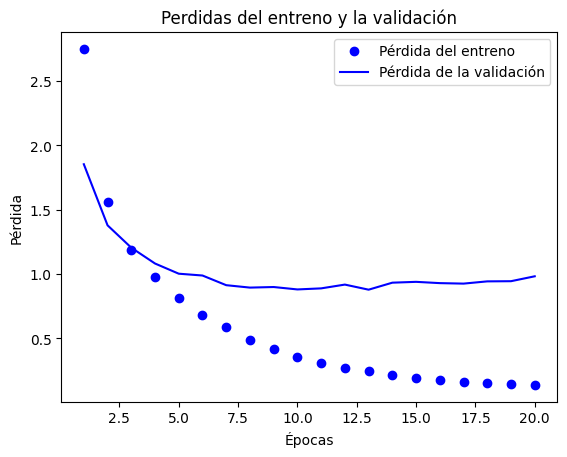

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Pérdida del entreno')
plt.plot(epochs, val_loss, 'b', label='Pérdida de la validación')
plt.title('Perdidas del entreno y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

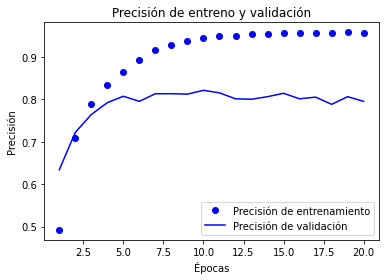

In [ ]:
plt.clf()   # Limpiamos el gráfico

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión de entreno y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

Parece que la red comienza a sobreajustarse después de 10 repeticiones (épocas). Entrenemos una nueva red desde cero durante 10 épocas, luego evaluémosla con el conjunto de prueba:

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Entreno con todos los datos durante 10 épocas
model.fit(x_train,
          one_hot_train_labels,
          epochs=10,
          batch_size=512)
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/10
18/18 [==============================] - 1s 13ms/step - loss: 2.5257 - accuracy: 0.5229
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 1.4262 - accuracy: 0.6994
Epoch 3/10
18/18 [==============================] - 0s 14ms/step - loss: 1.1082 - accuracy: 0.7623
Epoch 4/10
18/18 [==============================] - 0s 15ms/step - loss: 0.9061 - accuracy: 0.8019
Epoch 5/10
18/18 [==============================] - 0s 14ms/step - loss: 0.7453 - accuracy: 0.8360
Epoch 6/10
18/18 [==============================] - 0s 13ms/step - loss: 0.6149 - accuracy: 0.8686
Epoch 7/10
18/18 [==============================] - 0s 16ms/step - loss: 0.5069 - accuracy: 0.8948
Epoch 8/10
18/18 [==============================] - 0s 13ms/step - loss: 0.4252 - accuracy: 0.9087
Epoch 9/10
18/18 [==============================] - 0s 15ms/step - loss: 0.3557 - accuracy: 0.9240
Epoch 10/10
71/71 [==============================] - 0s 3ms/step - loss: 0.9176 - accuracy: 0.7947


In [19]:
results

[0.9692694544792175, 0.7804986834526062]

Este enfoque alcanza una precisión de ~ 78%. **Con un problema de clasificación binaria equilibrada, la precisión alcanzada por un clasificador puramente aleatorio sería del 50%**, pero en **nuestro caso** está más **cerca del 19%**, por lo que nuestros **resultados parecen bastante buenos**, al menos **en comparación con una línea de base aleatoria**:

In [21]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19857524487978628

## Generar predicciones en datos nuevos

Podemos verificar que el método `predict` de nuestra instancia del modelo devuelve una distribución de probabilidad sobre los 46 temas. Generemos tema
predicciones para todos los datos de prueba:

In [22]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


Cada entrada en `predictions` es un vector de longitud 46:

In [23]:
predictions[0].shape

(46,)

Los coeficientes en este vector suman 1:

In [24]:
np.sum(predictions[0])

1.0

La mayor entrada es la clase predicha, es decir, la clase con la probabilidad más elevada:

In [25]:
np.argmax(predictions[0])

3

## Una forma diferente de manejar las etiquetas y la pérdida

Mencionamos anteriormente que otra forma de codificar las etiquetas sería convertirlas en un tensor entero, como tal:

In [26]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)
print(test_labels)

[ 3 10  1 ...  3  3 24]


Lo único que cambiaría es la **elección de la función de pérdida**. Nuestra pérdida anterior, `categorical_crossentropy`, espera que las etiquetas sigan una codificación categórica. Con etiquetas enteras, deberíamos usar `sparse_categorical_crossentropy`:

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

Esta **nueva función de pérdida sigue siendo matemáticamente la misma** que `categorical_crossentropy`; simplemente tiene una **interfaz diferente**.

## Lo importante de tener capas intermedias lo bastante grandes:

Mencionamos anteriormente que dado que nuestras **salidas finales eran de 46 dimensiones**, **deberíamos evitar capas intermedias con mucho menos de 46 unidades ocultas**. Ahora intentemos ver **qué sucede cuando introducimos un cuello de botella de información** al tener capas intermedias significativamente menores que
46 dimensiones, p. Ej. 4 dimensiones.

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 2.6130 - accuracy: 0.5293 - val_loss: 1.8224 - val_accuracy: 0.6010
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5899 - accuracy: 0.6565 - val_loss: 1.4700 - val_accuracy: 0.6590
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2989 - accuracy: 0.6924 - val_loss: 1.3554 - val_accuracy: 0.6850
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1400 - accuracy: 0.7260 - val_loss: 1.3612 - val_accuracy: 0.6960
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.0326 - accuracy: 0.7403 - val_loss: 1.2783 - val_accuracy: 0.7000
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9554 - accuracy: 0.7506 - val_loss: 1.2869 - val_accuracy: 0.6990
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8891 - accuracy: 0.7637 - val_loss: 1.2632 - val_accuracy: 0.7000
Epoch 8/20
63/63 [=

Ahora la red llega aproximadamente al 71% de exactitud de la validación, **una caída absoluta del 8%**. Esta caída se debe principalmente al hecho de que ahora **estamos tratando de comprimir mucha información (información suficiente para recuperar los hiperplanos de separación de 46 clases) en un espacio intermedio de muy pocas dimensiones**. La red es **capaz de meter la mayor parte de la información necesaria en estas representaciones de 4 dimensiones, pero no toda**.

## Más experimentos

* Intenta usar capas más grandes o más pequeñas: 32 unidades, 128 unidades ...
* Estábamos usando dos capas ocultas. Ahora intenta crear una sola capa oculta o tres capas ocultas.

## Resumen

Esto es lo que debéis sacar de este ejemplo:

* Si estáis **intentando clasificar puntos de datos entre N clases, vuestra red debería terminar con una capa `Dense` de tamaño N**.
* En un problema de **clasificación de una sola etiqueta asignada y varias clases**, la red debe **terminar con una activación tipo "softmax"**, de modo que genere un distribución de probabilidad sobre las N clases de salida.
* **`categorical_crossentropy` es casi siempre la función de pérdida que debe usar para estos problemas**. Minimiza la distancia entre las distribuciones de probabilidad producidas por la red y la verdadera distribución de los objetivos.
* Hay **dos formas de manejar etiquetas en clasificación multiclase**:
  - Codificar las etiquetas a través de "codificación categórica" ​​(también conocida como **"codificación one-hot"**) y **usar `categorical_crossentropy` como su función de pérdida**.
  - Codificando las **etiquetas como números enteros** y usando la **función de pérdida `sparse_categorical_crossentropy`**.
* Si necesitamos **clasificar datos en una gran cantidad de categorías**, debemos **evitar crear cuellos de botella de información** en la red al tener capas intermedias que son demasiado pequeñas.

---